# Decision tree step by step

In [1]:
%load_ext autoreload
%autoreload 2
import os

In [2]:
# ! pip install ipywidgets
# ! jupyter nbextension enable --py widgetsnbextension

In [3]:
##### GOOGLE COLAB ######
if not os.path.exists('./decision_trees_utils.py'):
    ! wget https://raw.githubusercontent.com/davidggphy/2019_03_Curso_IFT/master/notebooks/01_classification/decision_trees_utils.py
if not os.path.exists('./plot_confusion_matrix.py'):
    ! wget https://raw.githubusercontent.com/davidggphy/2019_03_Curso_IFT/master/notebooks/01_classification/plot_confusion_matrix.py

In [4]:
from decision_trees_utils import cart_plot,multiple_cart_plots,print_cart
from decision_trees_utils import number_of_splits
from plot_confusion_matrix import plot_confusion_matrix,plot_confusion_matrix2
from decision_trees_utils import tree_to_nodes

In [5]:
%matplotlib notebook
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
sns.set()
plt.style.use('seaborn-whitegrid')

## Creating and preprocessing the data

In [6]:
dic_data_A = {'n': 15 ,'mean': (0,2), 'cov' :((1,0),(0,2)), 'y' : 0 }  # RED
dic_data_B = {'n': 15 ,'mean': (0,0), 'cov' :((3,0),(0,1)), 'y' : 1 }  # BLUE
dic_data = {'A': dic_data_A, 'B' : dic_data_B }

# We sample the points with numpy
np.random.seed(1)
samples = {key : np.random.multivariate_normal(dic['mean'], np.array(dic['cov']), dic['n']) 
           for key,dic in dic_data.items()}
     
X = np.concatenate(tuple(samples[key] for key in dic_data.keys() ),axis=0)
Y = np.concatenate(tuple(dic['y']* np.ones(dic['n'], dtype='int') 
                         for key,dic in dic_data.items() ), axis=0)



# Train Test Split
X_train,X_test,Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)

In [7]:
colors = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g ,b  in 150*np.eye(3)[[0,2,1]][np.array(Y_train,dtype='int')]
]
colors_test = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g ,b  in 150*np.eye(3)[[0,2,1]][np.array(Y_test,dtype='int')]
]
x0_range = (X[:,0].min()-1,X[:,0].max()+1)
x1_range = (X[:,1].min()-1,X[:,1].max()+1)
x0 = X_train[:,0] 
x1 = X_train[:,1] 
x0_test = X_test[:,0] 
x1_test = X_test[:,1] 

<IPython.core.display.Javascript object>


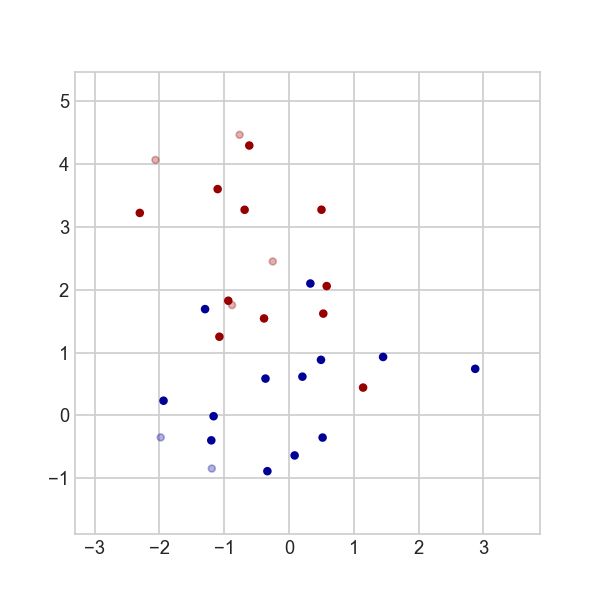

In [8]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_xlim(x0_range)
ax.set_ylim(x1_range)
# ax.xlim(x0_range)
# ax.ylim(x1_range)
# TRAIN
ax.scatter(x0, x1, s = 17, 
          alpha=1, c=colors )
# TEST
ax.scatter(x0_test, x1_test, s = 17, 
          alpha=0.3, c=colors_test )

ax.figure.canvas.draw()

## Logistic Regression with sklearn

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
clf_log = LogisticRegression(solver='lbfgs').fit(X_train,Y_train)
print(sklearn.metrics.classification_report(Y_test,clf_log.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [10]:
print(sklearn.metrics.classification_report(Y_train,clf_log.predict(X_train)))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.85      0.85      0.85        13

   micro avg       0.83      0.83      0.83        24
   macro avg       0.83      0.83      0.83        24
weighted avg       0.83      0.83      0.83        24



We can extract the coefficients of the linear regression to plot the decision boundary

In [11]:
# Coefficients of the linear regression's bondary. Bias and slopes
bias = clf_log.intercept_[0]
b0, b1 = tuple(clf_log.coef_[0])
x_line = x0_range
y_line = tuple(-(bias+b0*x)/b1 for x in x_line)

<IPython.core.display.Javascript object>


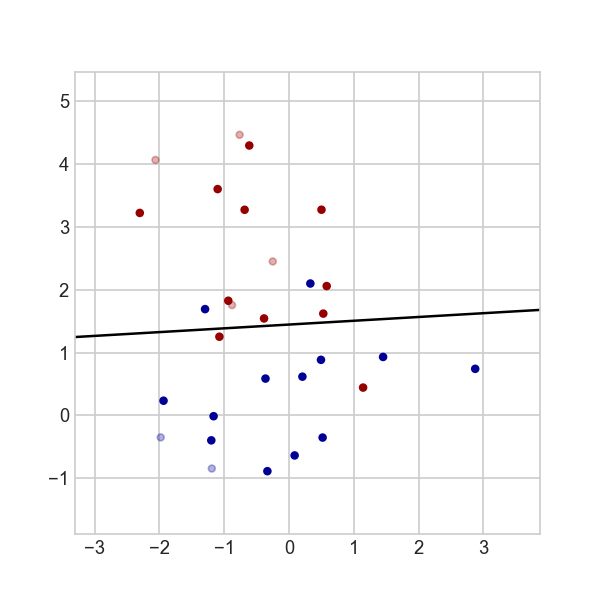

In [12]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_xlim(x0_range)
ax.set_ylim(x1_range)
# ax.xlim(x0_range)
# ax.ylim(x1_range)
# TRAIN
ax.scatter(x0, x1, s = 17, 
          alpha=1, c=colors )
# TEST
ax.scatter(x0_test, x1_test, s = 17, 
          alpha=0.3, c=colors_test )
# LINE
ax.plot(x_line,y_line, c='black')
# PLOT ALL
ax.figure.canvas.draw()

## Classification Decision Tree with Sklearn

In [13]:
from sklearn import tree
from decision_trees_utils import add_interacting_boundaries, add_boundaries
clf = tree.DecisionTreeClassifier(criterion='gini').fit(X_train, Y_train)
clf_ent = tree.DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
clf1 = tree.DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=3).fit(X_train, Y_train)
clf2 = tree.DecisionTreeClassifier(max_depth=2).fit(X_train, Y_train)
print(sklearn.metrics.classification_report(Y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



<IPython.core.display.Javascript object>


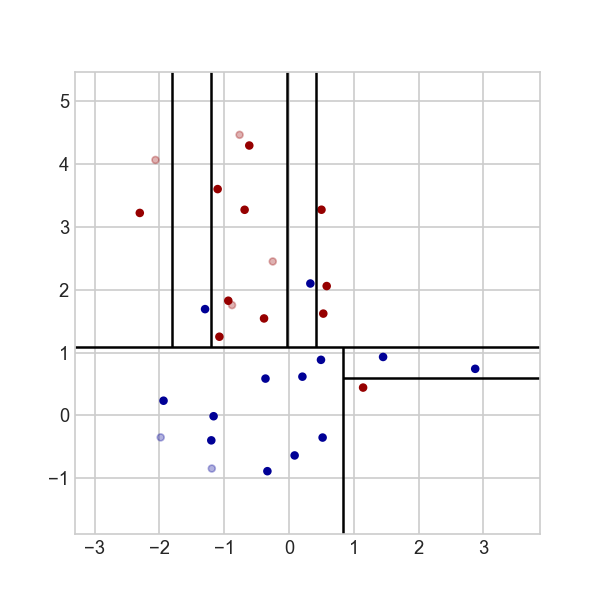

In [14]:
fig, ax = plt.subplots(figsize=(5,5))

ax.set_xlim(x0_range)
ax.set_ylim(x1_range)


ax.scatter(x0, x1, s = 17, # radius=radii,
          alpha=1, c=colors )
ax.scatter(x0_test, x1_test, s = 17, # radius=radii,
          alpha=0.3, c=colors_test )

# Counts the number of elements that the plot has w/o including the boundaries
n_collections_min = len(ax.collections)
ax.figure.canvas.draw()

add_boundaries(ax,clf)

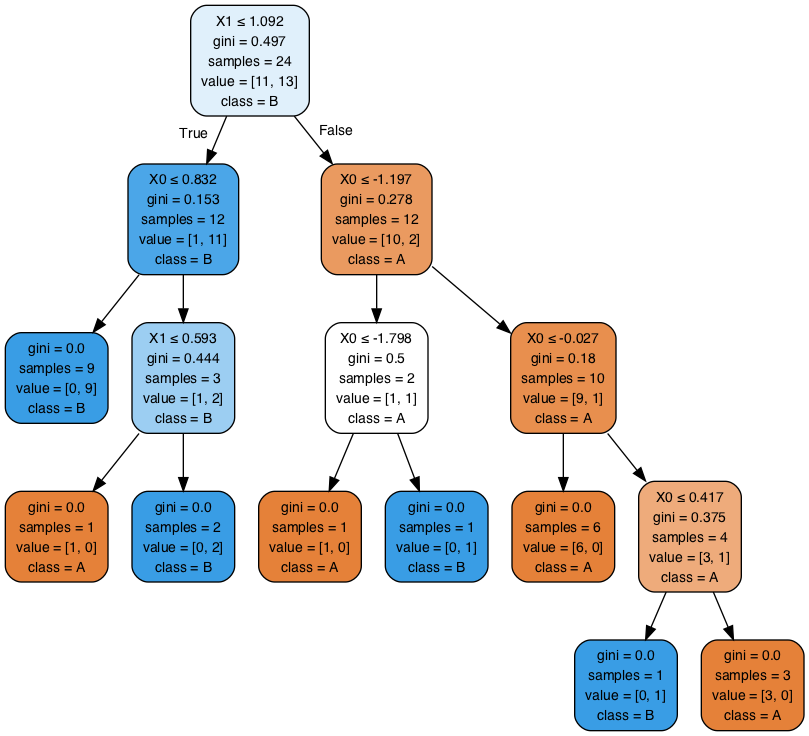

In [15]:
print_cart(clf)

<IPython.core.display.Javascript object>


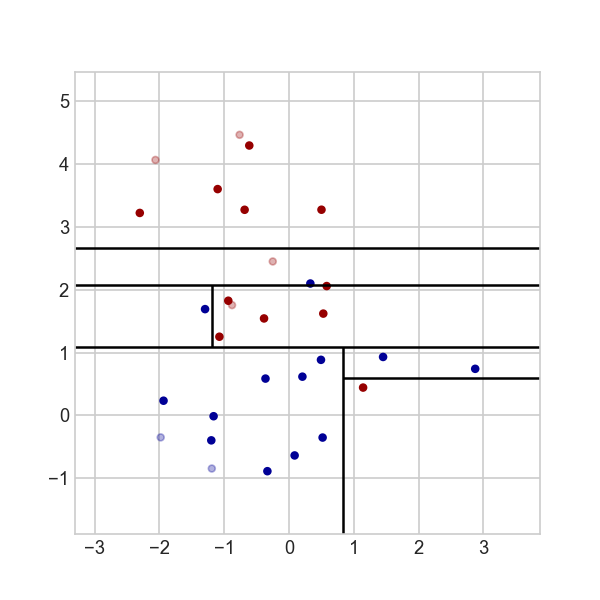

In [16]:
fig, ax = plt.subplots(figsize=(5,5))

ax.set_xlim(x0_range)
ax.set_ylim(x1_range)


ax.scatter(x0, x1, s = 17, # radius=radii,
          alpha=1, c=colors )
ax.scatter(x0_test, x1_test, s = 17, # radius=radii,
          alpha=0.3, c=colors_test )

# Counts the number of elements that the plot has w/o including the boundaries
n_collections_min = len(ax.collections)
ax.figure.canvas.draw()

add_boundaries(ax,clf_ent)

<IPython.core.display.Javascript object>


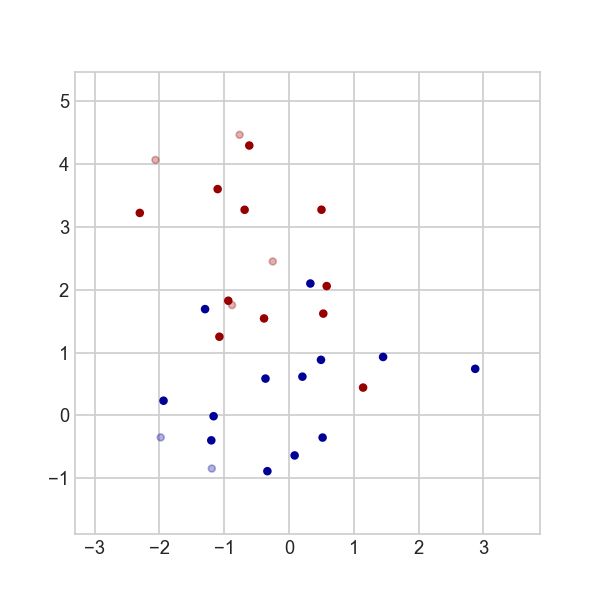

interactive(children=(IntSlider(value=3, description='step', max=7), Output()), _dom_classes=('widget-interact…

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

ax.set_xlim(x0_range)
ax.set_ylim(x1_range)


ax.scatter(x0, x1, s = 17, # radius=radii,
          alpha=1, c=colors )
ax.scatter(x0_test, x1_test, s = 17, # radius=radii,
          alpha=0.3, c=colors_test )

# Counts the number of elements that the plot has w/o including the boundaries
n_collections_min = len(ax.collections)
ax.figure.canvas.draw()

add_interacting_boundaries(ax,clf)

## Some lessons

**Properties:**
- The decision tree behaves as a nested set of if else conditions.
- Interpretable (at least the first nodes)
    -  We can know why we got a prediction
    -  Contrast with common sense and domain knowledge
- Decision trees will overfit
- But will generalize using next parameters:
    -  min_samples_leaf
    -  min_samples_split 
    -  max_depth 
    -  max_leaf_nodes
- Compared to a plain logistic regression, decision trees are slower (no vectorization), but really fast (we can do hyperparameter optimization)
- We have many hyperparameters (size of data, depth of tree, etc)
- No standarization / normalization (Using original units we will be able to understand the tree better)
- Remember that decision boundaries are always orthogonal to the axis, PCA can be useful
- Feature selection for free (not used if it not important clf.feature_importances_)
- Ordinal categorical variables are treated nicely (They have an intrinsic order, and grouped with neighbours)
- Low stability (Small changes in data, can cause a big change in the model)


## Decision Tree from scratch

In [11]:
from collections import namedtuple
class NestedNode(namedtuple('NestedNode', 'feature, threshold, left_node, right_node')):
    pass
class Node(namedtuple('Node', 'feature, threshold, left, right')):
    pass

def entropy(n_classes): 
    probs = n_classes/np.sum(n_classes)
    ent = -np.sum(probs * np.log2(probs+1e-10) )
    return ent

def get_best_split(X, Y, class_values = [0,1]):
    best_split = None
    best_entropy = 999.
    # Column vector, we will need it to broadcast later
    class_values = np.array(class_values).reshape((1,-1))
    
    for feature, values_feature in enumerate(X.T): # feature is the string naming each input feature
        values_sorted = np.sort(values_feature)
#         column = x[feature] # This is the array of the values
        for index, value in enumerate(values_sorted[:-1]):
            # LEFT PART, <= value
            n_classes = np.sum((Y_train[X_train[:,0]<=value].reshape((-1,1)) == class_values),axis=0)
            prob_left = np.sum(n_classes)/Y.size
            ent_left = entropy(n_classes)
            # RIGTH PART, > value
            n_classes = np.sum((Y_train[X_train[:,0] > value].reshape((-1,1)) == class_values),axis=0)
            prob_right = np.sum(n_classes)/Y.size
            ent_right = entropy(n_classes)
            ent_split = prob_left * ent_left + prob_right * ent_right 
            if ent_split < best_entropy:
                best_split = (feature, (value+values_sorted[index+1])/2) 
                best_entropy = ent_split
    return best_split

def train_decision_tree(X, Y, class_values = [0,1], min_samples_leaf=1):
    feature, value = get_best_split(X, Y, class_values= class_values)
    X_left, Y_left = X[X[:,feature] <= value], Y[X[:,feature] <= value]
#     x_left, y_left = x[x[feature] < value], y[x[feature] < value] 
    if (np.unique(Y_left).size > 1)and(Y_left.size > min_samples_leaf):
        left_node = train_decision_tree(X_left, Y_left,class_values=class_values, min_samples_leaf=min_samples_leaf) 
    else:
        left_node = None
    X_right, Y_right = X[X[:,feature] > value], Y[X[:,feature] > value]
#     x_right, y_right = x[x[feature] >= value], y[x[feature] >= value] 
    if (np.unique(Y_right).size > 1)and(Y_right.size > min_samples_leaf):
        right_node = train_decision_tree(X_right, Y_right,class_values=class_values, min_samples_leaf=min_samples_leaf) 
    else:
        right_node = None
    return NestedNode(feature, value, left_node, right_node)

Let's apply it

In [14]:
train_decision_tree(X_train,Y_train)

/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


NestedNode(feature=0, threshold=-0.3729348901408408, left_node=NestedNode(feature=1, threshold=1.3985427810141715, left_node=NestedNode(feature=0, threshold=-1.1178005125747834, left_node=None, right_node=None), right_node=NestedNode(feature=0, threshold=-1.7978274114766029, left_node=None, right_node=NestedNode(feature=0, threshold=-0.4979053841592455, left_node=NestedNode(feature=1, threshold=1.759330788708093, left_node=None, right_node=None), right_node=None))), right_node=NestedNode(feature=0, threshold=1.298942804688922, left_node=NestedNode(feature=0, threshold=-0.3470421745008113, left_node=None, right_node=NestedNode(feature=1, threshold=0.04561979304202557, left_node=None, right_node=NestedNode(feature=1, threshold=1.8404241488592894, left_node=NestedNode(feature=0, threshold=0.5125036120381303, left_node=None, right_node=None), right_node=NestedNode(feature=1, threshold=2.079977194801308, left_node=None, right_node=NestedNode(feature=1, threshold=2.6876484806254526, left_nod

We can compare it with the sklearn one

In [15]:
clf_ent = sklearn.tree.DecisionTreeClassifier(criterion='entropy').fit(X_train,Y_train)
tree_to_nodes(clf_ent)

[Node(feature='X1', threshold=1.092077225446701, left=1, right=6),
 Node(feature='X0', threshold=0.8323169350624084, left=2, right=3),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature='X1', threshold=0.5927667915821075, left=4, right=5),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature='X1', threshold=2.662063241004944, left=7, right=12),
 Node(feature='X1', threshold=2.07997727394104, left=8, right=11),
 Node(feature='X0', threshold=-1.1835423707962036, left=9, right=10),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature=None, threshold=-2.0, left=-1, right=-1)]

## Exercise: 

Implement the Decission Tree Classifier using the gini index instead of the entropy

In [ ]:
def gini(a, b): 
    ### TODO
    return gin

In [ ]:
def gini(n_classes): 
    probs = n_classes/np.sum(n_classes)
    gini = 1-np.sum(np.power(probs,2 ) )
    return gini

## Another implementation
https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/

In [236]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right
 
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini
 
# Select the best split point for a dataset
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
# Create a terminal node value
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left)
		split(node['left'], max_depth, min_size, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right)
		split(node['right'], max_depth, min_size, depth+1)
 
# Build a decision tree
def build_tree(train, max_depth, min_size):
	root = get_split(train)
	split(root, max_depth, min_size, 1)
	return root
 
# Print a decision tree
def print_tree(node, depth=0):
	if isinstance(node, dict):
		print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
		print_tree(node['left'], depth+1)
		print_tree(node['right'], depth+1)
	else:
		print('%s[%s]' % ((depth*' ', node)))
 

dataset = np.hstack([X_train,Y_train.reshape((-1,1))])
tree = build_tree(dataset, 15, 5)
print_tree(tree)

[X2 < 2.288]
 [X2 < 1.225]
  [X2 < -1.726]
   [1.0]
   [X1 < 0.387]
    [0.0]
    [X1 < 0.387]
     [0.0]
     [0.0]
  [X1 < 0.302]
   [1.0]
   [0.0]
 [X1 < -0.977]
  [1.0]
  [X1 < -0.977]
   [1.0]
   [1.0]


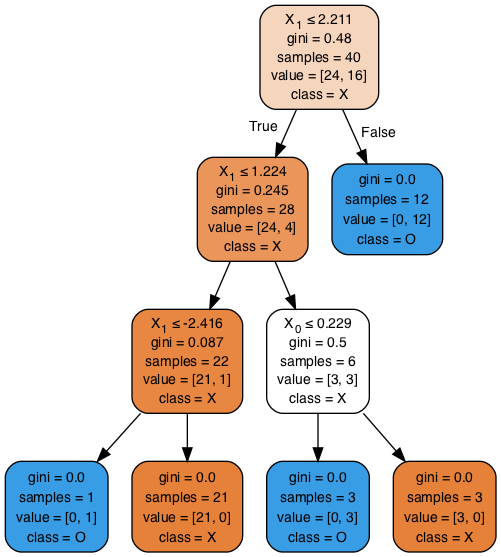

In [230]:
print_cart(clf)